In [1]:
import os
import subprocess
import gdal
import json
import cv2
from osgeo import osr
import shutil
import tempfile
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
input_dir = 'data/original/train'
train_files = sorted(os.listdir(input_dir))
train_files = list(filter(lambda fname: not fname.endswith('_mask.tif'), train_files))
train_files = list(map(lambda fname: os.path.splitext(fname)[0], train_files))
print(len(train_files))

5635


In [3]:
def load(name):
    img = cv2.imread(os.path.join(input_dir, name + '.tif'))
    mask = cv2.imread(os.path.join(input_dir, name + '_mask.tif'))
    return img, mask

In [4]:
def arbitrary_georeference(filename):
    """Modifies filename georeference to force it to something arbitrary"""
    ds = gdal.Open(filename, gdal.gdalconst.GA_Update)
    assert ds is not None, 'Failed to open %s' % output_filename
    # Specify raster location through geotransform array
    # (uperleftx, scalex, skewx, uperlefty, skewy, scaley)
    # Scale = size of one pixel in units of raster projection
    pixel_size = 0.1
    gt = [0, pixel_size, 0, 0, 0, -pixel_size]
    # Set location
    err = ds.SetGeoTransform(gt)
    assert err == gdal.gdalconst.CE_None, 'Failed to set geotransform'
    # Get raster projection
    epsg = 3857
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    ds.SetProjection(dest_wkt)
    ds.FlushCache()

def pixel_polygons_to_geojson(fname, polygons):
    ds = gdal.Open(fname)
    img_proj = ds.GetProjection()
    geot = ds.GetGeoTransform()
    img_srs = osr.SpatialReference(wkt=img_proj)
    wgs84_srs = osr.SpatialReference()
    wgs84_srs.ImportFromEPSG(4326)

    img_to_wgs84 = osr.CoordinateTransformation(img_srs, wgs84_srs)
    
    fc = {
        'type': 'FeatureCollection',
        'features': []
    }

    for polygon in polygons:
        coords = []
        for ring in polygon:
            coords_ring = []
            for x, y in ring:
                x += 0.5
                y += 0.5
                x_geo = geot[0] + x * geot[1] + y * geot[2]
                y_geo = geot[3] + x * geot[4] + y * geot[5]
                lng, lat, _ = img_to_wgs84.TransformPoint(x_geo, y_geo)
                coords_ring.append((lng, lat))
            # close it (need to duplicate point in geojson)
            coords_ring.append(coords_ring[0])
            coords.append(coords_ring)
        fc['features'].append({
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': coords
            },
            'properties': {}
        })
        
    return fc

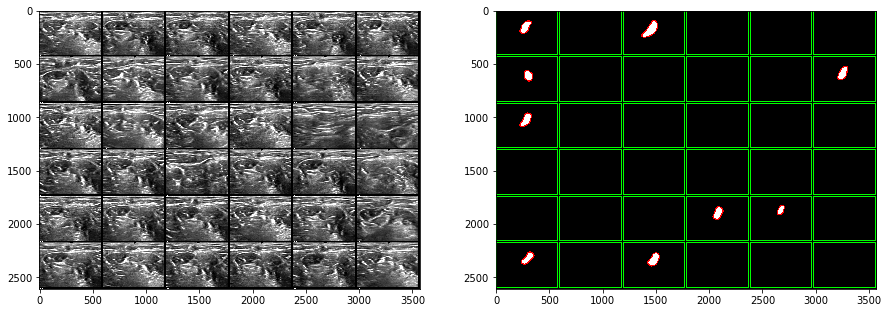

In [5]:
OPENCV_MAJOR_VERSION = cv2.__version__.split('.')[0]


def find_contours(*args, **kwargs):
    # Depending on the opencv version, findContours will return 2 or 3 values
    ret = cv2.findContours(*args, **kwargs)
    if OPENCV_MAJOR_VERSION == '3':
        _, contours, hierarchy = ret
    else:
        contours, hierarchy = ret
    return contours, hierarchy


def extract_contours(mask):
    contours, _ = find_contours(mask[..., 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [
        np.array([cv2.approxPolyDP(contour, epsilon=3, closed=False).squeeze()])
        for contour in contours
    ]
    return contours


def make_mosaic(files, imshape=(420, 580)):
    v = np.sqrt(len(files))
    rows, cols = int(np.round(v)), int(np.ceil(v))
    
    margin = 15
    
    out_img = np.zeros(((imshape[0] + margin) * rows, (imshape[1] + margin) * cols, 3), dtype=np.uint8)
    out_mask = np.zeros(((imshape[0] + margin) * rows, (imshape[1] + margin) * cols, 3), dtype=np.uint8)
    
    image_areas = []
    
    for index, name in enumerate(files):
        img, mask = load(name)
        row = index // cols
        col = index % cols
        i_from = row * (imshape[0] + margin)
        i_to = i_from + imshape[0]
        j_from = col * (imshape[1] + margin)
        j_to = j_from + imshape[1]
        out_img[i_from:i_to, j_from:j_to, :] = img
        out_mask[i_from:i_to, j_from:j_to, :] = mask
        
        image_areas.append(np.array([[
            (j_from + 1, i_from + 1), (j_to - 1, i_from + 1), (j_to - 1, i_to - 1), (j_from + 1, i_to - 1)
        ]]))
        
        cv2.putText(out_img, name, (j_from + 4, i_to + margin - 4), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255))

    annotations = extract_contours(out_mask)

    return out_img, out_mask, annotations, image_areas


def plot_mosaic(img, mask, annotations, areas):
    vmask = mask.copy()
    pl.figure(figsize=(15, 8))
    pl.subplot(121)
    pl.imshow(img)
    pl.subplot(122)
    cv2.drawContours(vmask, annotations, -1, (255, 0, 0), 10)
    cv2.drawContours(vmask, areas, -1, (0, 255, 0), 10)
    pl.imshow(vmask)

def save_mosaic(prefix, img, mask, annotations, areas, plot=True):
    if plot:
        plot_mosaic(img, mask, annotations, areas)

    fname = '%s.tif' % prefix
    cv2.imwrite(fname, img)
    arbitrary_georeference(fname)
    with open('%s_annotations.geojson' % prefix, 'w') as f:
        json.dump(pixel_polygons_to_geojson(fname, annotations), f)
    with open('%s_areas.geojson' % prefix, 'w') as f:
        json.dump(pixel_polygons_to_geojson(fname, areas), f)

save_mosaic(
    'data/testmosaic',
    *make_mosaic(train_files[:36]),
    plot=True
)

Generate mosaics for all the train files

In [8]:
outdir = 'data/mosaics'
os.makedirs(outdir, exist_ok=True)

chunksize = 100
for i in range(0, len(train_files), chunksize):
#for i in range(0, 1000, chunksize):
    save_mosaic(
        '%s/mosaic_%d_%d' % (outdir, i, i+chunksize),
        *make_mosaic(train_files[i:i+chunksize]),
        plot=False
    )